In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft2
from skimage.filters import window


import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_temporal_profile(sta, dt):
    tap = sta.shape[0]
#     figsize = (5.5,3.5)
#     plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    plt.ylabel('STA')
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    # print('PSNR = {:.2f}'.format(psnr(sta)))

    plt.title('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel('ms')
    
    
def plot_temporal_spectrum(sta, dt):
    wt = rfft(sta, axis=1)
    
    N = sta.shape[1]
    fs = rfftfreq(N, dt)
    
    plt.plot(fs, np.abs(wt.T), 'o-')
    plt.xlabel('Hz')
    plt.ylabel('FFT amplitude')

    box_off()


def plot_spatial_spectrum(sta_slice, windowing='hann', pixel_size=1, precision=2):
    assert len(sta_slice.shape)==2
    
    def set_ticks(ax, fs, precision=precision):
        ticks = range(0, len(fs))
        print_format = "{:." + str(precision) + "f}"
        ticklabels = [print_format.format(p) for p in (fs)]

        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_xlim(-0.5, len(fs)-0.5)
#         from matplotlib.ticker import FormatStrFormatter
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_ylim(-0.5, len(fs)-0.5)

        
    w = fft2(sta_slice * window(windowing, sta_slice.shape))

    fs = rfftfreq(sta_slice.shape[0])
    
    # crop and take abs w 
    abs_w = np.abs(w[:len(fs),:len(fs)])
    plt.imshow(abs_w, cmap='gray', origin='lower')

    set_ticks(plt.gca(), fs, precision=precision)
    
    plt.xlabel('frequency')
    plt.ylabel('frequency')
    
    abs_w[0,0] = - np.Inf
    idx_max = np.unravel_index(np.argmax(abs_w, axis=None), abs_w.shape)
    plt.plot(idx_max[1],idx_max[0], 'r*')
    
    
    
def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    
    plot_temporal_profile(sta, dt)
    
    
#     pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
#     if ylabel is not None:
#         plt.ylabel(ylabel)
#     print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     print('PSNR = {:.2f}'.format(psnr(sta)))
# #     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

In [3]:
def calc_spatial_spectrum(sta_reg):
    # find pixel with highest variance
    idx_max_var = np.argmax(np.var(sta_reg,axis=0))
    temporal_profile = sta_reg[:,idx_max_var]

    plt.figure(figsize=(12,4))
    plt.plot(temporal_profile, '.-')
    idx_peak = np.argmax(np.abs(temporal_profile))

    sta_slice = sta_reg[idx_peak,:].reshape(height,width)
    plt.plot(idx_peak, sta_reg[idx_peak, idx_max_var], 'r*')
    plt.xlabel('frame')
    plt.ylabel('STA at pixel {}'.format(idx_max_var))
    box_off()


    sta_slice = sta_reg[idx_peak,:].reshape(height,width)


    plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.imshow(sta_slice, cmap='gray', origin='lower')

    plt.subplot(122)
    plot_spatial_spectrum(sta_slice)

## load data

In [4]:
# data_path = 'data'

# # dataset = '20201209'
# # width = 26
# # height = 26

# # dataset = '20201216'
# # width = 13
# # height = 13

# dataset = '20180626'
# width = 8
# height = 8
# fps = 10

In [5]:
# gaussian stim with the highest contrast
data_path = 'data_gaussian'
dataset = 'contrast100'
dataset = 'contrast50'

width = 8
height = 8
fps = 10

In [6]:
# different spatial & temporal resolutions (2018.08.28)
data_path = 'data_binary_stim'

# width = 8
# height = 8
# fps = 10

# width = 8
# height = 8
# fps = 25

# width = 13
# height = 13
# fps = 10

width = 26
height = 26
fps = 10

dataset = '20180828_{}pix_{}Hz'.format(width,fps)
dataset

'20180828_26pix_10Hz'

In [7]:
# cloud stim data (2021.01.13)
# ln -s ~/data/cloud_stim_data data_cloud_stim
data_path = 'data_cloud_stim'

dataset = '20210113'
width = 26
height = 26
fps = 10

In [8]:
# cloud stim data (2021.02.03 - 52x52, 30Hz)
# ln -s ~/data/cloud_stim_data data_cloud_stim
data_path = 'data_cloud_stim'
dataset = '20210203_contrast100'
width = 52
height = 52
fps = 30

In [9]:
data = np.load(os.path.join(data_path, dataset + '.npz'))
info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))


stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

102

(array([48672000.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 48672000.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

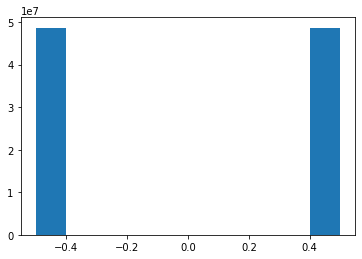

In [10]:
plt.hist(stim.ravel())

In [11]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20
elif fps == 30:
    tap = 24

## calc STA and peak-to-peak difference for all RGCs

In [12]:
# choose a channel
sta_p2ps = []
sta_psnrs = []

for ch_idx in range(spike_counts.shape[0]):

    channel_name = info['channel'][ch_idx]
    cell_types = info['cell_type'][ch_idx]
    print(channel_name, cell_types)
    

    spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

    sta = np.average(spike_triggered_stim, weights=weights, axis=0)
    # sta.shape
    
    sta_p2ps.append(p2p(sta))
    sta_psnrs.append(psnr(sta))

#     print(spike_triggered_stim.shape)

#     plot_spatio_temporal(sta, ylabel='STA') #, 
#     #                     fig_basename=os.path.join('figure', 'sta', channel_name))
#     # plt.title(channel_name + '(%.2f)'.format)

info['sta_p2p'] = sta_p2ps
info['sta_psnr'] = sta_psnrs

info.to_csv(dataset + '_sta.csv', index=None)

12a ON-OFF
12b ON-OFF
13a ON-OFF
13b Unknown
14a ON
14b Unknown
16a ON-OFF
16b ON
17a ON
17b ON
17c ON
17d ON-OFF
17e Unknown
21a ON-OFF
22a ON-OFF
23a Unknown
23b ON
24a ON
24b ON
25a ON-OFF
25b Unknown
26a ON-OFF
26b ON
28a ON
28b ON-OFF
31a ON
31b ON
31c ON
32a ON-OFF
32b ON
33a ON-OFF
33b Unknown
34a ON
34b ON
35a OFF
35b ON-OFF
36a OFF
36b ON-OFF
37a Unknown
37b Unknown
38a Unknown
38b ON
41a ON-OFF
41b ON
42a ON-OFF
42b ON
43a ON-OFF
43b ON
43c Unknown
46a OFF
46b ON-OFF
46c ON
46d Unknown
47a ON
47b ON
51a OFF
51b ON-OFF
52a OFF
52b ON-OFF
52c ON-OFF
55a Unknown
55b ON
56a ON
56b ON
57a Unknown
57b Unknown
57c Unknown
61a ON-OFF
61b ON
61c ON
61d ON
62a ON-OFF
62b ON-OFF
63a ON
64a ON
64b ON-OFF
67a ON-OFF
67b ON
67c Unknown
68a ON-OFF
68b ON-OFF
71a ON
71b Unknown
71c Unknown
76a ON-OFF
76b ON
77a OFF
77b Unknown
77c ON
78a ON-OFF
78b ON
83a ON-OFF
83b ON
84a OFF
84b ON
84c ON-OFF
85a ON
85b Unknown
86a OFF
86b ON
87a ON-OFF
87b Unknown


## analyze results

In [13]:
# # dataset = '20201209'
# # info = pd.read_csv('20201209_sta.csv')

# dataset = '20201216'
# info = pd.read_csv('20201216_sta.csv')


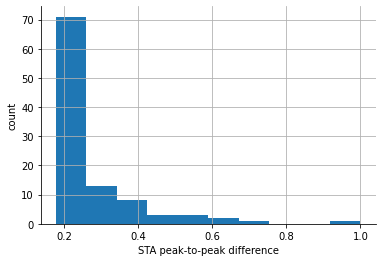

In [14]:
info['sta_p2p'].hist()
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('count')
box_off()

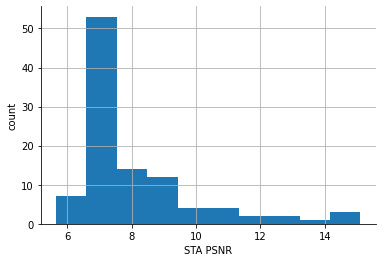

In [15]:
info['sta_psnr'].hist()
plt.xlabel('STA PSNR')
plt.ylabel('count')
box_off()

In [16]:
idx_high_snr = info['sta_p2p'] >= 0.35
info[idx_high_snr].sort_values(by='sta_p2p', ascending=False)

,channel,cell_type,sta_p2p,sta_psnr
78,67c,Unknown,1.000000,5.656375
12,17e,Unknown,0.685535,7.953524
69,61c,ON,0.663693,12.180119
47,43b,ON,0.630145,15.103784
90,78b,ON,0.587876,13.562688
31,33b,Unknown,0.579726,12.960963
48,43c,Unknown,0.566062,14.412871
101,87b,Unknown,0.505087,14.163722
51,46c,ON,0.486957,8.772746
3,13b,Unknown,0.434503,11.520436


In [17]:
if len(info['cell_type'].value_counts()) == 3: # ON, OFF, Unknown
    group_values = ['ON', 'OFF', 'Unknown']
    color=['r','#00A0FF', '#A0A0A0']
elif len(info['cell_type'].value_counts()) == 4: # ON, OFF, ON-OFF, Unknown
    group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown']
    color=['r','#00A0FF','green', '#A0A0A0']    

In [18]:
info.groupby('cell_type', sort=False).mean()

,sta_p2p,sta_psnr
cell_type,,
ON-OFF,0.218246,7.315837
Unknown,0.338154,8.366613
ON,0.282481,8.282616
OFF,0.266463,8.824637


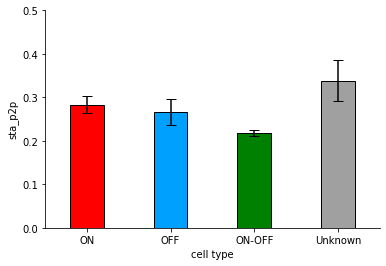

In [19]:
plot_bar_by_group(info, 'sta_p2p',
                  group_values = group_values, color=color)

plt.ylim(0, 0.5)
plt.savefig("figure/sta_{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta_{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [20]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.667070620682317
0.2565837911367882


In [21]:
idx_high_snr = info['sta_psnr'] >= 8
info[idx_high_snr].sort_values(by='sta_psnr', ascending=False)

,channel,cell_type,sta_p2p,sta_psnr
47,43b,ON,0.630145,15.103784
48,43c,Unknown,0.566062,14.412871
101,87b,Unknown,0.505087,14.163722
90,78b,ON,0.587876,13.562688
31,33b,Unknown,0.579726,12.960963
86,77a,OFF,0.403156,12.396100
69,61c,ON,0.663693,12.180119
3,13b,Unknown,0.434503,11.520436
55,51a,OFF,0.360571,11.057175
24,28b,ON-OFF,0.372266,10.727982


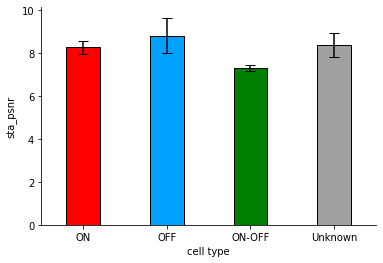

In [22]:
plot_bar_by_group(info, 'sta_psnr',
                  group_values = group_values, color=color)

plt.savefig("figure/sta_{}_psnr_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta_{}_psnr_bar.png".format(dataset), bbox_inches='tight')

In [23]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_psnr', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

# t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['ON-OFF'], equal_var=False)
# print(p)

0.5552782749030594
0.9920496096431126


## spatio-temporal analysis of RF with ON or OFF RGC with high peak-to-peak difference

In [24]:
# choose a channel with highest p2p
idx_on = info['cell_type'] == 'ON'
idx_off = info['cell_type'] == 'OFF'
idx = np.logical_or(idx_on, idx_off)

ch_idx = info.loc[idx]['sta_p2p'].idxmax()
# ch_idx = info.loc[idx]['sta_psnr'].idxmax()   #PSNR is better criteria

In [25]:
channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

61c ON


peak-to-peak diff. = 0.66


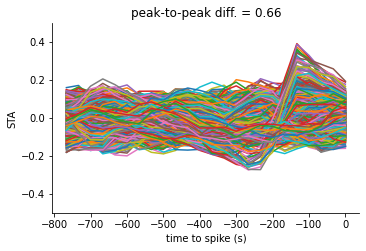

<Figure size 432x288 with 0 Axes>

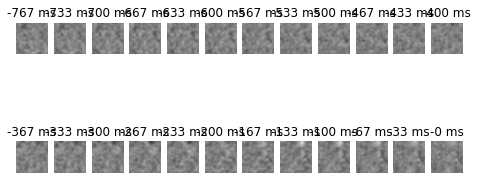

In [26]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20
elif fps == 25:
    tap = 24

sta = pysta.calc_sta(stim, spike_counts[ch_idx], tap=tap)

import os
if not os.path.exists(os.path.join('figure', dataset)):
    os.makedirs(os.path.join('figure', dataset))
    
plot_spatio_temporal(sta, 
                     width=width, height=height, dt=1000/fps,
                     ylabel='STA',
                     fig_basename=os.path.join('figure', dataset, channel_name+'_sta'))
# plt.title(channel_name + '(%.2f)'.format)

### spatial spectrum

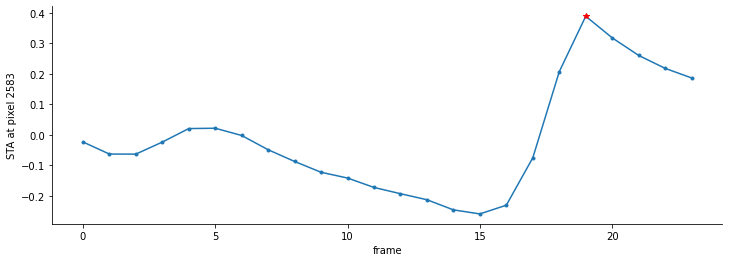

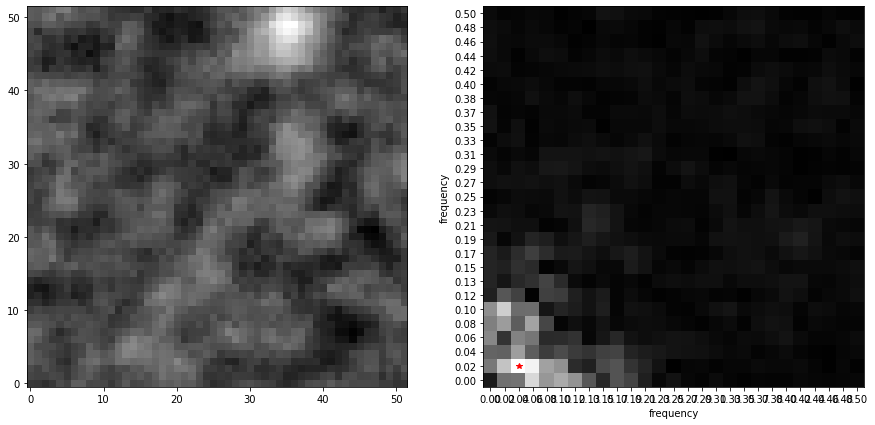

In [27]:
calc_spatial_spectrum(sta)

plt.savefig(os.path.join('figure',dataset, channel_name + '_sta_space_spectrum.pdf'))

### temporal spectrum

peak-to-peak diff. = 0.66


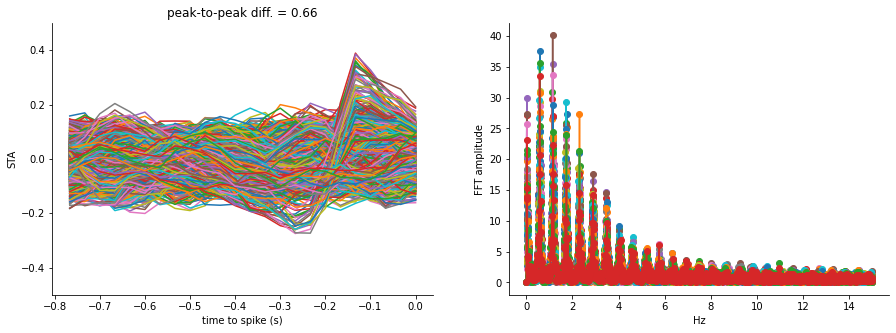

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plot_temporal_profile(sta, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(sta, 1/fps)

plt.savefig(os.path.join('figure',dataset, channel_name + '_sta_temp_spectrum.pdf'))

In [29]:
# actual frequency values
rfftfreq(tap, 1/fps)

array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
       11.25, 12.5 , 13.75, 15.  ])

## calc regularized STA

In [1]:
sta_reg = pysta.normalize_sta(stim, sta)

NameError: name 'pysta' is not defined

In [ ]:
plot_spatio_temporal(sta_reg, 
                     width=width, height=height, dt=1000/fps,
                     ylabel='rSTA')
#                      fig_basename=os.path.join('figure', 'rsta', channel_name))

In [ ]:
# spatial spectrum
calc_spatial_spectrum(sta_reg)

plt.savefig(os.path.join('figure',dataset, channel_name + '_rsta_space_spectrum.pdf'))

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plot_temporal_profile(sta_reg, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(sta_reg, 1/fps)

plt.savefig(os.path.join('figure',dataset, channel_name + '_rsta_temp_spectrum.pdf'))
